In [2]:
# The code was removed by Watson Studio for sharing.

### About the dataset
In this notebook, available data will be scraped from the biggest deal platform in Germany, Mydealz.  
Mydealz is a social media shopping platform where users create deals about offers of popular products.  
The data features are degree (a deal classifier), description, merchant (where a product can be bought), price and title.  
I will be primarily focusing on deals that contain the keyword "Mediamarkt" in either title or description, in order to find out what products of Mediamarkt are most wanted by consumers.  
Also, I will only scrape the latest 2600 deals, since May 2018, because new products are introduced very frequently into the market and others become outdated.  
A word cloud will be used to visualize the most used keywords in the user deal title.

### Scraping the data
First, let's define a function for user agent switching otherwise the scraping attempts would easily be blocked:

In [1]:
from bs4 import BeautifulSoup
import json
import urllib.request as urllib2
import random
from random import choice
import time
from datetime import datetime

def urlquery(url):
    # function cycles randomly through different user agents and time intervals to simulate more natural queries
    try:
        sleeptime = float(random.randint(1,3))/5
        time.sleep(sleeptime)

        agents = ['Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_2) AppleWebKit/537.17 (KHTML, like Gecko) Chrome/24.0.1309.0 Safari/537.17',
        'Mozilla/5.0 (compatible; MSIE 10.6; Windows NT 6.1; Trident/5.0; InfoPath.2; SLCC1; .NET CLR 3.0.4506.2152; .NET CLR 3.5.30729; .NET CLR 2.0.50727) 3gpp-gba UNTRUSTED/1.0',
        'Opera/12.80 (Windows NT 5.1; U; en) Presto/2.10.289 Version/12.02',
        'Mozilla/4.0 (compatible; MSIE 5.5; Windows NT)',
        'Mozilla/3.0',
        'Mozilla/5.0 (iPhone; U; CPU like Mac OS X; en) AppleWebKit/420+ (KHTML, like Gecko) Version/3.0 Mobile/1A543a Safari/419.3',
        'Mozilla/5.0 (Linux; U; Android 0.5; en-us) AppleWebKit/522+ (KHTML, like Gecko) Safari/419.3',
        'Opera/9.00 (Windows NT 5.1; U; en)']

        agent = choice(agents)
        opener = urllib2.build_opener()
        opener.addheaders = [('User-agent', agent)]

        html = opener.open(url).read()
        time.sleep(sleeptime)
        
        return html

    except Exception as e:
        print('Something went wrong with Crawling:\n%s' % e)

Next, let's define a function that takes the search results from Mydealz platform and assigns certain features of that page to a dictionary "local".  
Eventually, the dictionary of each page is assigned to a dataframe "mydealz".

In [2]:
def dealparser(url):
    
    ''' Parser takes search results from mydealz.de'''
    
    try:
        soup = BeautifulSoup(urlquery(url), 'html.parser')
        articles = soup.find_all('article')
        namedata = []
        pricedata = []
        descdata = []
        merchdata = []
        timedata = []
        degreedata = []
        for article in articles:
            names = article.find_all('a', class_ ='cept-tt thread-link linkPlain thread-title--list')
            for name in names:
                namedata.append(name.text.strip())
            prices = article.find_all('span', class_ ='thread-price')
            if len(prices) > 0:
                for price in prices:
                    pricedata.append(price.text.strip())
                    break
            else:
                pricedata.append('NaN')
            descriptions = article.find_all('div', class_='cept-description-container')
            for description in descriptions:
                descdata.append(description.text.strip()[0:180])
            merchants = article.find_all('span', class_='cept-merchant-name')
            if len(merchants) > 0:
                for merchant in merchants:
                    merchdata.append(merchant.text.strip())
            else:
                merchdata.append('NaN')
            degrees = article.find_all('span', class_='cept-vote-temp')
            if len(degrees) > 0:
                for degree in degrees: 
                    degreedata.append(degree.text.strip())
            else:
                degreedata.append('NaN')
        print("Titles: {},".format(len(namedata)), "Descriptions: {},".format(len(descdata)),"Prices {},".format(len(pricedata)), "Merchants: {}".format(len(merchdata)),"Degrees: {}".format(len(degreedata)))
        local = {'title': namedata,'description': descdata, 'price': pricedata, 'merchant':merchdata, 'degrees': degreedata}
        return local
    except Exception as e:
        print("Error in mydealz parser: %s" % e)

Let's write a loop that scrapes the first 130 pages from Mydealz that contain the keyword "Mediamarkt":

In [6]:
import pandas as pd
import re

# define the dataframe columns
column_names = ['title','description','price', 'merchant', 'degrees'] 

# instantiate the dataframe
mydealz = pd.DataFrame(columns=column_names)

page = 0

while page < 130:
        page +=1
        print('Searching Page %s' % (page))
        url = 'https://www.mydealz.de/search?q=mediamarkt&page={}/'.format(page)
        try:
            local = dealparser(url)
            if local != None:
                mydealz = mydealz.append(pd.DataFrame.from_dict(local),ignore_index=True)
            else:
                page -=1
        except:
            page-=1

Searching Page 1
Titles: 20, Descriptions: 20, Prices 20, Merchants: 20 Degrees: 20
Searching Page 2
Titles: 20, Descriptions: 0, Prices 20, Merchants: 20 Degrees: 20
Searching Page 2
Titles: 20, Descriptions: 20, Prices 20, Merchants: 20 Degrees: 20
Searching Page 3
Titles: 20, Descriptions: 20, Prices 20, Merchants: 20 Degrees: 20
Searching Page 4
Titles: 20, Descriptions: 20, Prices 20, Merchants: 20 Degrees: 20
Searching Page 5
Titles: 20, Descriptions: 20, Prices 20, Merchants: 20 Degrees: 20
Searching Page 6
Titles: 20, Descriptions: 20, Prices 20, Merchants: 20 Degrees: 20
Searching Page 7
Titles: 20, Descriptions: 20, Prices 20, Merchants: 20 Degrees: 20
Searching Page 8
Titles: 20, Descriptions: 20, Prices 20, Merchants: 20 Degrees: 20
Searching Page 9
Titles: 20, Descriptions: 0, Prices 20, Merchants: 20 Degrees: 20
Searching Page 9
Titles: 20, Descriptions: 20, Prices 20, Merchants: 20 Degrees: 20
Searching Page 10
Titles: 20, Descriptions: 20, Prices 20, Merchants: 20 Degre

Let's see who the primary merchant of deals with the keyword "Mediamarkt" is:

In [16]:
mydealz.groupby(['merchant'])['merchant'].count().sort_values(ascending=False).head(10)

merchant
Media Markt                    1459
NaN                             409
eBay                            239
Amazon                          178
Saturn                          103
Media Markt Schweiz (CH)         24
Media Markt Österreich (AT)      24
notebooksbilliger.de              8
EURONICS                          6
PAYBACK                           5
Name: merchant, dtype: int64

Let's take a quick look at the dataframe before we save it and do some analysis later:

In [8]:
mydealz

,degrees,description,merchant,price,title
0,95°,"Hallo, bei MediaMarkt über ebay erhaltet Ihr ...",eBay,"24,30€","Remington Bartschneider MB350L für 24,30€ bei ..."
1,41°,"Hallo zusammen, im MediaMarkt Kempten (ALLGÄU)...",NaN,629€,[LOKAL MEDIAMARKT KEMPTEN] SONOS PLAYBAR
2,424°,Bei Mediamarkt in Castrop Rauxel gefunden. Da...,NaN,249€,Sony WH1000 XM3| Lokal Mediamarkt Castrop Rauxel
3,350°,Gerade im MediaMarkt im Breuningerland Ludwigs...,NaN,250€,Sony WH1000XM3 Kopfhörer/ MediaMarkt Ludwigsburg
4,115°,Hallo Guyz. In Berlin Alexanderplatz MediaMark...,NaN,155€,Samsung Gear S3 Frontier 46mm Space Gray Lokal...
5,315°,"Hi, bei eBay-Saturn und eBay-MediaMarkt bekomm...",eBay,"67,50€","SanDisk Ultra A1 microSDXC 400GB für 67,50€ [e..."
6,NaN,"Hallo zusammen, mein erster Deal, also bitte ...",eBay,4.283€,LG OLED 77 C8 LLA (MediaMarkt)
7,NaN,"Hallo liebe Gemeinde, dies ist mein erster Dea...",NaN,379€,[Lokal MediaMarkt Meerane] (2 Wochen vor Relea...
8,87°,Den 65AF8 gibt es aktuell im MediaMarkt Äppela...,NaN,2.319€,[LOKAL MEDIAMARKT ÄPPELALLEE Wiesbaden] SONY 6...
9,572°,Aktuell gibt es bei ebay das Xbox One X Bundle...,eBay,"341,10€",Xbox One X über ebay mit POWERFRIDAY Coupon - ...


In [10]:
project.save_data(data=mydealz.to_csv(index=False),file_name='mydealz.csv',overwrite=True)

{'asset_id': 'da04860d-91be-4a68-949d-6756e5367ece',
 'bucket_name': 'myproject-donotdelete-pr-y3piceksvnj4ep',
 'file_name': 'mydealz.csv',
 'message': 'File mydealz.csv has been written successfully to the associated OS'}

In [1]:
# The code was removed by Watson Studio for sharing.

,degrees,description,merchant,price,title
0,95°,"Hallo, bei MediaMarkt über ebay erhaltet Ihr ...",eBay,"24,30€","Remington Bartschneider MB350L für 24,30€ bei ..."
1,41°,"Hallo zusammen, im MediaMarkt Kempten (ALLGÄU)...",NaN,629€,[LOKAL MEDIAMARKT KEMPTEN] SONOS PLAYBAR
2,424°,Bei Mediamarkt in Castrop Rauxel gefunden. Da...,NaN,249€,Sony WH1000 XM3| Lokal Mediamarkt Castrop Rauxel
3,350°,Gerade im MediaMarkt im Breuningerland Ludwigs...,NaN,250€,Sony WH1000XM3 Kopfhörer/ MediaMarkt Ludwigsburg
4,115°,Hallo Guyz. In Berlin Alexanderplatz MediaMark...,NaN,155€,Samsung Gear S3 Frontier 46mm Space Gray Lokal...


In [2]:
# install wordcloud
!conda install -c conda-forge wordcloud==1.4.1 --yes

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
wordcloud                 1.4.1                    py35_0    conda-forge
Wordcloud is installed and imported!


### Creating a word cloud
Alright, before we can generate the wordcloud, let's create a word cloud object and define a stopwords set:

In [3]:
stopwords = set(STOPWORDS)

In [4]:
# instantiate a word cloud object
customer_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
words = ''
for element in df_data_1['title']:
    words = words + element
customer_wc.generate(words)

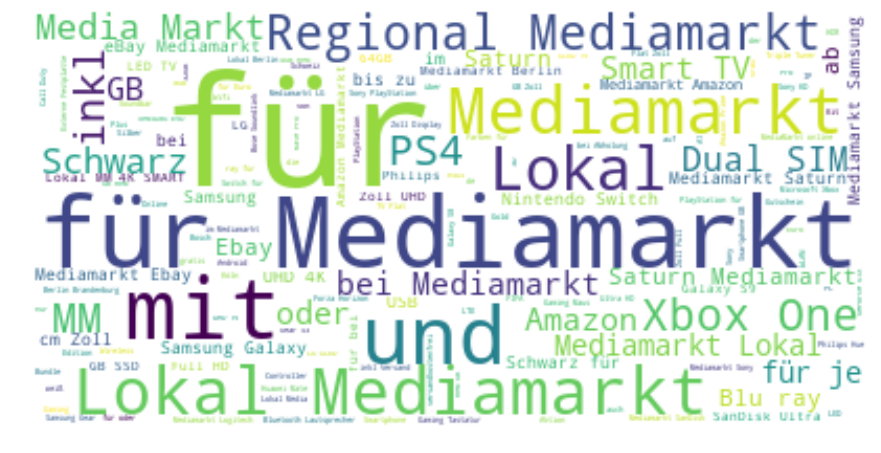

In [5]:
from matplotlib import pyplot as plt

# display the word cloud
plt.figure(figsize=(15,8))
plt.imshow(customer_wc, interpolation='bilinear')
plt.axis('off')
plt.show()
plt.savefig("foo.png", dpi=300)

Clearly, the three stores Mediamarkt, Amazon, Saturn seem to come up most in Mediamarkt deals.  
Since we are focusing on products, not stores, let's remove these and some other words with stopwords:

In [6]:
stopwords.update(['Mediamarkt', 'für', 'und', 'mit', 'Lokal', 'Regional', 'Amazon', 'MM', 'Media Markt', 'Saturn', ])

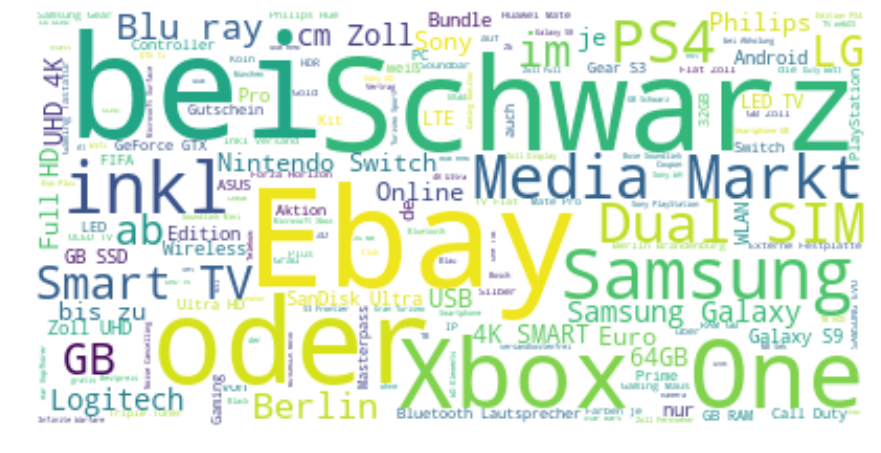

In [7]:
# instantiate a word cloud object
customer_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
customer_wc.generate(words)

# display the word cloud
plt.figure(figsize=(15,8))
plt.imshow(customer_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Better, but still not very good.  
Ebay seems to come up very often too. Also, let's get rid of locations such as Berlin.  
Let's add some more stopwords:

In [8]:
stopwords.update(['bei', 'Ebay', 'oder', 'Media', 'Markt', 'Schwarz', 'GB', 'ab', 'inkl', 'nur'])

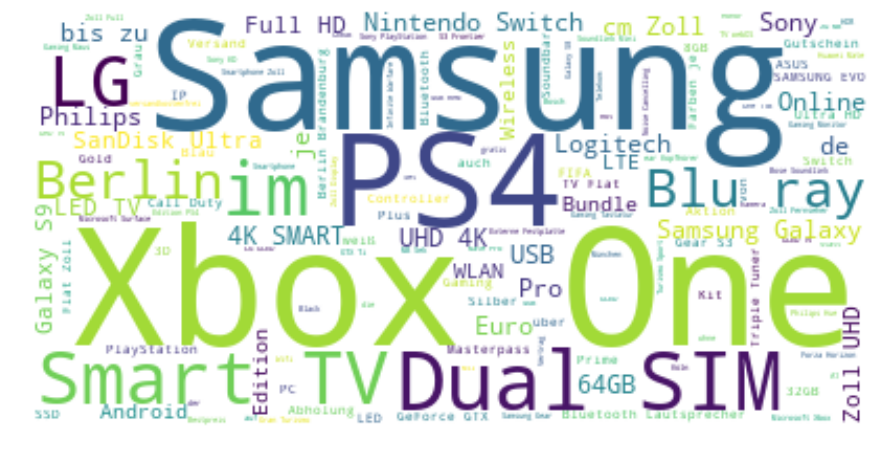

In [9]:
customer_wc = WordCloud(
    background_color='white',
    max_words=200000,
    stopwords=stopwords
)

# generate the word cloud
customer_wc.generate(words)

# display the word cloud
plt.figure(figsize=(15,8))
plt.imshow(customer_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Looks pretty good already.  
Let's add some final stopwords:

In [10]:
stopwords.update(['im', 'bis', 'zu', 'Berlin', 'cm', 'Zoll', 'Blau', 'je', 'Edition', 'über', 'Prime', 'Pro', 'de', 'Euro', 'Abholung', 'auch', 'Online', 'Versand'])

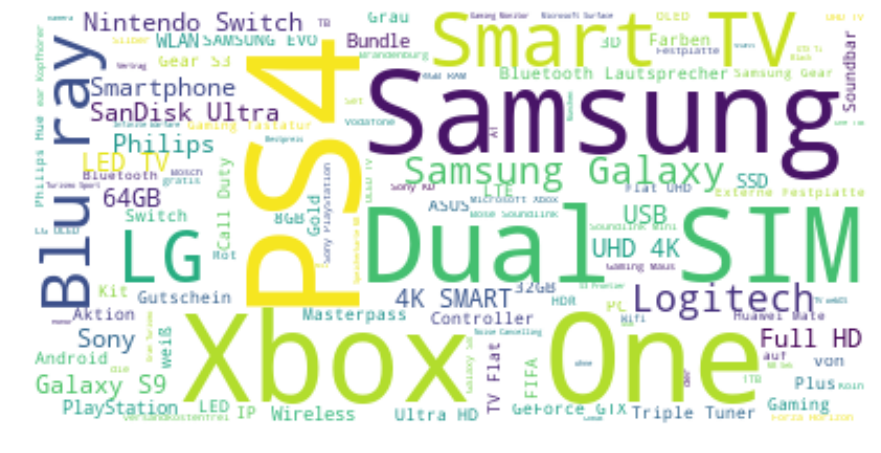

In [11]:
customer_wc = WordCloud(
    background_color='white',
    max_words=200000,
    stopwords=stopwords
)

# generate the word cloud
customer_wc.generate(words)

# display the word cloud
plt.figure(figsize=(15,8))
plt.imshow(customer_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Apparently, customers of Mediamarkt care most about products such as Xbox One, PS4, Samsung, Dual SIM smartphones, LG, Blu-ray, 4K Smart TV's, Nintendo Switch, Philips, Logitech, Sony and Samsung Galaxy Smartphones.